# Time sensitive star rating by topic 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from gensim import corpora, models, similarities
from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
import seaborn as sns
import random
import numpy as np
import nltk
from sklearn.model_selection import train_test_split

In [2]:
business = pd.read_csv('chinese_business_clean.csv')
reviews = pd.read_csv('chinese_reviews_clean.csv')

### Study the characteristics of dataset

In [3]:
grouped = reviews.groupby('business_id')
data = []
for i, df in grouped:
    df = df.sort_values(by = 'date')
    data.append({'business_id':i,\
                'review_count':len(df),
                'oldest':df['date'].values[0],\
                'latest':df['date'].values[-1]})

In [4]:
review_stats = pd.DataFrame(data)
review_stats.sort_values(by='review_count', ascending = False).head()

,business_id,latest,oldest,review_count
3692,yfxDa8RFOvJPQh0rNtakHA,2017-07-25,2007-01-03,2446
3088,pH0BLkL4cbxKzu471VZnuA,2017-07-24,2008-07-21,1972
1944,X8c23dur0ll2D9XTu-I8Qg,2017-07-25,2013-04-18,1548
953,GJ_bXUPv672YwNg4TneJog,2017-07-25,2010-12-20,1319
2312,cHdJXLlKNWixBXpDwEGb_A,2017-07-24,2005-11-24,1262


In [5]:
print ('{} businesses'.format(len(review_stats)))

3774 businesses


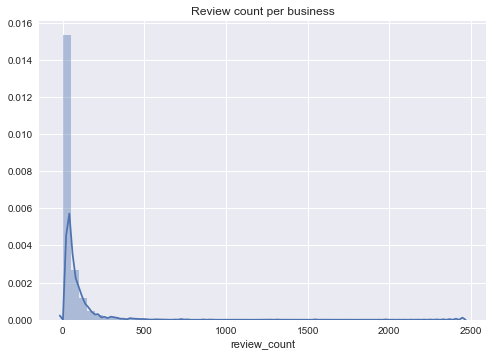

In [6]:
sns.distplot(review_stats['review_count'])
plt.title('Review count per business')
plt.show()

In [7]:
review_stats = review_stats.loc[review_stats['review_count'] > 50]

In [8]:
print ('{} businesses'.format(len(review_stats)))

957 businesses


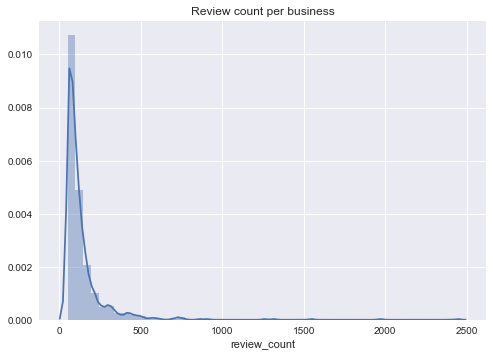

In [9]:
sns.distplot(review_stats['review_count'])
plt.title('Review count per business')
plt.show()

In [10]:
lda =  models.LdaModel.load('gensim/lda.model')
dictionary = corpora.Dictionary.load('gensim/chinsese_dict.dict')

In [11]:
def tokenize(text):
    return [token for token in simple_preprocess(text) if token not in STOPWORDS]

def embed(text, model, dictionary):
    text = tokenize(text)
    bow = dictionary.doc2bow(text)
    kindex = model.get_document_topics(bow)
    out = [0] * model.num_topics
    for i, p in kindex:
        out[i] = p
    return np.array(out) 

def embed_sent(text, model, dictionary):
    out = np.array([0.]*128)
    sentences = len(nltk.sent_tokenize(text))
    for text in nltk.sent_tokenize(text):
        out += embed(text, lda, dictionary)
    return (out/sentences)

In [12]:
embed_sent(reviews['text'][3], lda, dictionary)

array([ 0.        ,  0.        ,  0.09567309,  0.        ,  0.20526037,
        0.04452289,  0.02118845,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.14355098,  0.        ,
        0.        ,  0.        ,  0.        ,  0.05873322,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.06038421,  0.        ,
        0.        ,  0.        ,  0.        ,  0.20654029,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.01015138,  0.        ,  0.01814084,
        0.        ,  0.00852534,  0.        ,  0.        ,  0.  

In [13]:
freq = np.array([0.] * lda.num_topics)
for text in (random.sample(set(reviews['text']), 1000)):
    freq += np.ceil(embed_sent(text, lda, dictionary))  

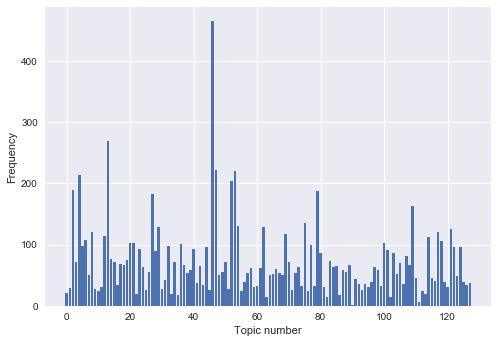

In [14]:
plt.bar(np.arange(lda.num_topics), freq)
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

In [15]:
np.argsort(freq)

array([ 90, 111, 102,  63,  82,  86,  35, 113,  22,  33,   0,  10,  76,
       112,  55,  71,  25,  93,  45,  51,   9,  30,   1,  95,  81,  11,
        59, 120,  60,  99,  78,  74, 126,  43,  16,  92,  94, 106,  41,
       127,  56, 119, 125,  96, 116,  31,  91, 115, 110, 123,   7,  68,
        48,  64, 104,  65,  38,  57,  67,  72,  26,  49,  88,  87,  39,
        98,  66,  58,  61,  84,  73,  97,  24,  85,  42, 108,  37,  89,
        18,  17, 105,  70,   3,  34,  50,  15,  83,  19,  14, 107, 103,
        80,  28, 101,  40,  23,  44, 124, 122,  32,   5,  77,  36,  21,
       100,  20, 118,   6, 114,  12,  69,   8, 117, 121,  62,  29,  54,
        75, 109,  27,  79,   2,  52,   4,  53,  47,  13,  46])

In [20]:
print (lda.print_topic(46) + '\n')
print (lda.print_topic(13) + '\n')
print (lda.print_topic(47) + '\n')

0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly" + 0.028*"staff" + 0.021*"amazing" + 0.016*"love" + 0.016*"delicious" + 0.014*"good"

0.072*"food" + 0.046*"chinese" + 0.029*"good" + 0.027*"place" + 0.015*"ve" + 0.014*"service" + 0.013*"best" + 0.012*"great" + 0.011*"time" + 0.010*"delivery"

0.028*"table" + 0.018*"food" + 0.018*"came" + 0.013*"minutes" + 0.013*"seated" + 0.012*"wait" + 0.011*"service" + 0.010*"waitress" + 0.009*"ordered" + 0.009*"got"



People seem to talk about waiting time for food, authenticity, delivery service.

What if we apply '1 topic per sentence rule'

In [17]:
freq = np.array([0.] * lda.num_topics)
for text in (random.sample(set(reviews['text']), 1000)):
    e = embed_sent(text, lda, dictionary)
    i = e.tolist().index(max(e))
    topic = np.array([0.] * lda.num_topics)
    topic[i] = 1.0
    freq += topic

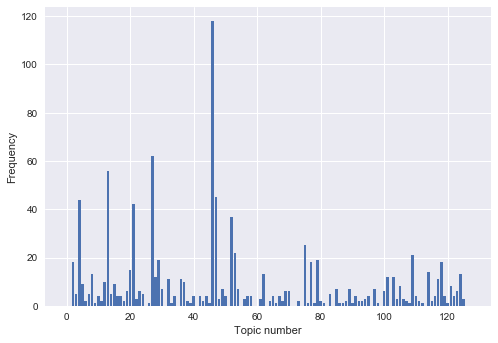

In [18]:
plt.bar(np.arange(lda.num_topics), freq)
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

In [19]:
np.argsort(freq)

array([  0,  35,  41,  51,  55,  59,  60, 126,  31,  71,  74,  82,  84,
        96,  99, 102, 113,  72,  25,  63, 127,   1,  86,  87,  78,  33,
        90,  76,   9,  98, 108,  26,  45, 112,  66, 120,  81,  39,  68,
        80,  88,  64,  92,  93, 107, 111, 115,   6,  11,  73,  43,  38,
        18,  94, 104,  61, 106,  48,  22, 125,  56, 110,  42, 116, 119,
        95, 122,  17,  91,  16,  40,  50,  34,  57,  58,  44,  10,  65,
        67,   7,  14,  24,   3,  83,  19, 123,  23, 100,  69,  70,  49,
        89,  85,  30,  54,  97, 105, 121,   5,  15,  37,  12,  32,  36,
       117,  28, 103, 101, 124,  62,   8, 114,  20,  77, 118,   2,  79,
        29, 109,  53,  75,  52,  21,   4,  47,  13,  27,  46])

In [21]:
# 27 emerged
print (lda.print_topic(27) + '\n')

0.040*"chicken" + 0.026*"rice" + 0.022*"fried" + 0.021*"food" + 0.021*"good" + 0.019*"egg" + 0.016*"soup" + 0.013*"sour" + 0.013*"chinese" + 0.011*"beef"



In [23]:
mat = []
for text in (random.sample(set(reviews['text']), 1000)):
    mat.append(embed_sent(text, lda, dictionary)) 

In [24]:
mat =np.array(mat)

In [25]:
np.corrcoef(mat.T)

array([[  1.00000000e+00,  -1.22337984e-02,   8.79097315e-03, ...,
         -2.13161329e-02,  -1.05311610e-04,  -6.07406263e-03],
       [ -1.22337984e-02,   1.00000000e+00,  -2.80551821e-02, ...,
         -1.96168514e-02,  -1.30415706e-02,  -1.47517692e-02],
       [  8.79097315e-03,  -2.80551821e-02,   1.00000000e+00, ...,
         -1.16212775e-03,   1.59166224e-02,  -1.32029752e-02],
       ..., 
       [ -2.13161329e-02,  -1.96168514e-02,  -1.16212775e-03, ...,
          1.00000000e+00,  -1.02031533e-02,   3.62385089e-02],
       [ -1.05311610e-04,  -1.30415706e-02,   1.59166224e-02, ...,
         -1.02031533e-02,   1.00000000e+00,  -1.27808284e-02],
       [ -6.07406263e-03,  -1.47517692e-02,  -1.32029752e-02, ...,
          3.62385089e-02,  -1.27808284e-02,   1.00000000e+00]])

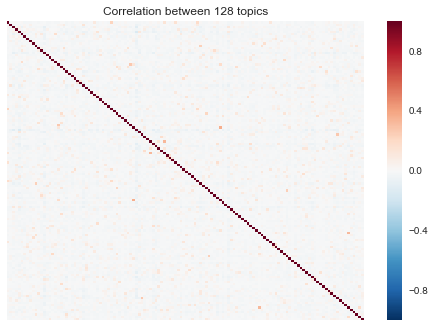

In [26]:
sns.heatmap(np.corrcoef(mat.T), xticklabels='', yticklabels='')
plt.title('Correlation between 128 topics')
plt.show()

## Is topic sufficient to predict star ratings

In [27]:
reviews5 = reviews[reviews['stars'] == 5]

In [28]:
freq = np.array([0.] * lda.num_topics)
for text in (random.sample(set(reviews5['text']), 1000)):
    freq += np.ceil(embed_sent(text, lda, dictionary))

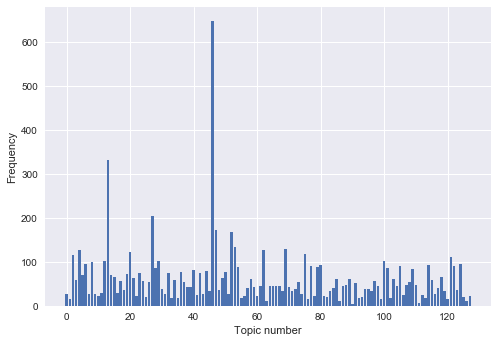

In [29]:
plt.bar(np.arange(lda.num_topics), freq)
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

In [30]:
np.argsort(freq)

array([ 90, 111,  63,  86, 126,  76, 120,   1,  99, 113,  35,  55,  33,
       102,  92,  25,  93,  82, 125,  81,  60,  10,  78,  56, 127,  22,
       112,  41, 106, 116,   7,   9,  74,   0,  31,  51,  43,  16,  11,
        83, 119,  96,  68,  45,  71, 123,  18,  48,  94,  95,  30,  72,
       117,  84,  57,  59,  70,  38,  39,  65,  64,  87,  67, 104,  98,
        66,  61, 107,  88, 110,  91,  73, 108,  37,  26,  17,  24,  97,
        34,   3, 115, 103,  89,  85,  58,  21,  49, 118,  15,   5,  14,
        19,  42,  32,  23,  36,  50,  44,  40, 109, 101,  28,  79,  54,
       122,  77, 105, 114,  80,   6, 124,   8, 100,  29,  12, 121,   2,
        75,  20,  62,   4,  69,  53,  52,  47,  27,  13,  46])

In [31]:
reviews1 = reviews[reviews['stars'] == 1]

In [32]:
freq = np.array([0.] * lda.num_topics)
for text in (random.sample(set(reviews1['text']), 1000)):
    freq += np.ceil(embed_sent(text, lda, dictionary))

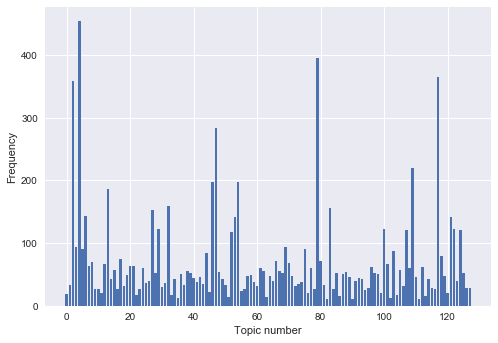

In [33]:
plt.bar(np.arange(lda.num_topics), freq)
plt.xlabel('Topic number')
plt.ylabel('Frequency')
plt.show()

In [34]:
np.argsort(freq)

array([111,  90,  82,  35, 102,  63,  51,  86, 113,  33,  22, 104,   0,
        11,  99,  76, 120,  45,  55,  94,  16,  78,  56, 116,  10,  84,
        23,   9,  95, 127, 126, 115,  30, 106,  18,  72,  60,   1,  50,
        37,  81,  73,  43,  25,  31,  74,  41,  59,  91,  26, 123,  65,
        14,  34,  93, 114,  49,  40,  92,  89, 110,  42,  64,  57, 119,
        71,  58,  19,  87,  36,  98,  97,  28, 125,  85,  39,  68,  88,
        48,  38,  67,  62,  15, 105,  77,  24, 108,  61,  96, 112,   7,
        21,  20, 101,  12,  70,   8,  80,  66,  17, 118,  44, 103,   5,
        75,   3,  69,  52, 107, 124, 100, 122,  29,  53, 121,   6,  27,
        83,  32,  13,  46,  54, 109,  47,   2, 117,  79,   4])

In [35]:
print ('Top 3 positive topics')
print (lda.print_topic(46) + '\n')
print (lda.print_topic(13) + '\n')
print (lda.print_topic(27) + '\n')

print ('Top 3 negative topics')
print (lda.print_topic(4) + '\n')
print (lda.print_topic(79) + '\n')
print (lda.print_topic(117) + '\n')

Top 3 positive topics
0.061*"food" + 0.054*"great" + 0.029*"service" + 0.028*"place" + 0.028*"friendly" + 0.028*"staff" + 0.021*"amazing" + 0.016*"love" + 0.016*"delicious" + 0.014*"good"

0.072*"food" + 0.046*"chinese" + 0.029*"good" + 0.027*"place" + 0.015*"ve" + 0.014*"service" + 0.013*"best" + 0.012*"great" + 0.011*"time" + 0.010*"delivery"

0.040*"chicken" + 0.026*"rice" + 0.022*"fried" + 0.021*"food" + 0.021*"good" + 0.019*"egg" + 0.016*"soup" + 0.013*"sour" + 0.013*"chinese" + 0.011*"beef"

Top 3 negative topics
0.031*"order" + 0.029*"food" + 0.014*"said" + 0.011*"minutes" + 0.011*"ordered" + 0.011*"asked" + 0.011*"service" + 0.010*"place" + 0.010*"time" + 0.010*"like"

0.042*"food" + 0.024*"service" + 0.013*"place" + 0.011*"bad" + 0.009*"night" + 0.009*"good" + 0.008*"restaurant" + 0.008*"like" + 0.008*"time" + 0.007*"people"

0.030*"food" + 0.014*"like" + 0.010*"place" + 0.008*"rice" + 0.008*"time" + 0.007*"eat" + 0.007*"worst" + 0.007*"ordered" + 0.007*"service" + 0.007*"bad"

Overwhelming majority of negative reviews are about delivery and waiting time for the food

In [36]:
review_stats.sort_values(by='review_count', ascending = False)['business_id'].values[0]

'yfxDa8RFOvJPQh0rNtakHA'

In [37]:
data = reviews[reviews['business_id'] == 'yfxDa8RFOvJPQh0rNtakHA']
X_train, X_test, y_train, y_test = train_test_split(data['text'], data['stars'], test_size=0.20)

In [38]:
def generate_data(train):
    embed = []
    for text in train:
        embed.append(embed_sent(text, lda, dictionary))
    return np.array(embed)

In [39]:
%time train = generate_data(X_train)

CPU times: user 22.7 s, sys: 22.9 ms, total: 22.8 s
Wall time: 21.6 s


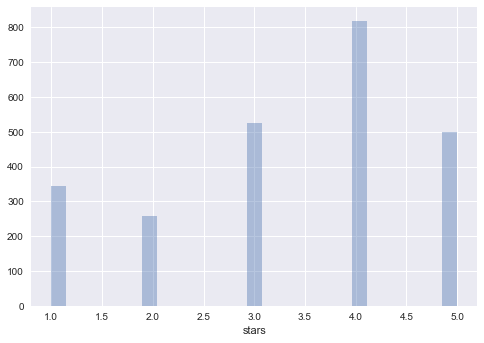

In [40]:
sns.distplot(data['stars'], kde = False)
plt.show()

In [41]:
from sklearn import svm
from sklearn.metrics import confusion_matrix

In [42]:
%time test = generate_data(X_test)

CPU times: user 6.2 s, sys: 15.7 ms, total: 6.21 s
Wall time: 5.39 s


In [43]:
clf = svm.SVC()
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0],
       [ 62,  61,  95, 169, 103],
       [  0,   0,   0,   0,   0]])

In [44]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[35, 21, 20, 29, 20],
       [14, 23, 23, 33, 15],
       [ 6,  6, 15, 20, 13],
       [ 1,  3, 11, 19, 15],
       [ 6,  8, 26, 68, 40]])

In [45]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=20, n_estimators=10, max_features=1)
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[  8,   7,   3,   4,   1],
       [  3,   3,   0,   0,   1],
       [ 12,  10,  10,  15,   5],
       [ 36,  36,  77, 139,  91],
       [  3,   5,   5,  11,   5]])

In [46]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(max_depth=20)
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[26, 16, 14,  4,  2],
       [10,  9, 10,  7,  2],
       [12, 20, 15, 44,  8],
       [11, 13, 44, 89, 44],
       [ 3,  3, 12, 25, 47]])

In [47]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier()
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[ 39,  15,  12,   9,   2],
       [  4,   4,   4,   5,   0],
       [  9,  18,  20,  24,   9],
       [  7,  22,  50, 101,  53],
       [  3,   2,   9,  30,  39]])

In [50]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (100, 95, 80, 75), activation = 'tanh', alpha=0.2, learning_rate = 'adaptive')
clf.fit(train, y_train)
confusion_matrix(clf.predict(test), y_test)

array([[43, 23, 15, 12,  3],
       [ 1,  7,  2,  1,  2],
       [10, 22, 34, 44, 19],
       [ 5,  8, 35, 78, 44],
       [ 3,  1,  9, 34, 35]])

In [52]:
clf.score(test, y_test)

0.4020408163265306